In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve

import tensorflow as tf
import keras 

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, InputLayer, Flatten, Conv2D, MaxPooling2D

np.random.seed(42)
tf.random.set_seed(42)

from preprocessing.getdata import *

In [48]:
df = get_csvdata()
dfTrain, dfTest, y_train, y_test = train_test_split(df, df['CDR'], stratify = df['CDR'], random_state=42)

In [49]:
N = 0
d = 1

X_test0 = get_slices(dfTest['ID'], dim=0, m=90, N=N, d=d)
X_test0 = np.repeat(X_test0[..., np.newaxis], 3, -1)

X_test1 = get_slices(dfTest['ID'], dim=1, m=90, N=N, d=d)
X_test1 = np.repeat(X_test1[..., np.newaxis], 3, -1)

X_test2 = get_slices(dfTest['ID'], dim=2, m=90, N=N, d=d)
X_test2 = np.repeat(X_test2[..., np.newaxis], 3, -1)

#y_test = y_test.repeat(1+2*N)

In [40]:
model0 = tf.keras.models.load_model('../models/dim0')
model1 = tf.keras.models.load_model('../models/dim1')
model2 = tf.keras.models.load_model('../models/dim2')

In [41]:
y_prob0 = model0.predict(X_test0)
y_prob1 = model1.predict(X_test1)
y_prob2 = model2.predict(X_test2)

2022-08-24 15:18:50.308721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-24 15:18:55.548772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-24 15:18:58.807929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [42]:
y_prob0 = y_prob0.reshape(len(dfTest),1+2*N)
y_prob1 = y_prob1.reshape(len(dfTest),1+2*N)
y_prob2 = y_prob2.reshape(len(dfTest),1+2*N)

In [43]:
y_prob0 = np.mean(y_prob0, axis=1)
y_prob1 = np.mean(y_prob1, axis=1)
y_prob2 = np.mean(y_prob2, axis=1)

In [44]:
y_prob = np.stack((y_prob0, y_prob1, y_prob2)).T

In [45]:
y_pred = np.mean(y_prob, axis=1).round()

accuracy:  0.7
recall:  0.7
precision:  0.7


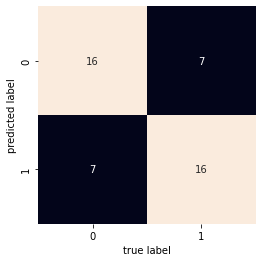

In [46]:
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test, y_pred.round()).round(2))
print('recall: ' , recall_score(y_test, y_pred.round()).round(2))
print('precision: ' , precision_score(y_test, y_pred.round()).round(2))